## Imported Modules

In [24]:
import tensorflow as tf
from keras import metrics
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, GlobalAveragePooling2D

import pandas as pd
import numpy as np
import os
import shutil
import pathlib
from glob import glob

import requests 
from bs4 import BeautifulSoup
import urllib.request

import PIL
from PIL import Image

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

## Global Variables

In [260]:
NUM_CLASSES = 2
NUM_EPOCHS = 5
BATCH_SIZE = 16
IMG_SIZE = (224,224) # Expected size for ResNet50
LR = 0.1

## Load Lucy Images

In [122]:
# Load and convert images to .jpeg

img_dir = "/Users/johngalvin/Desktop/GitHub/Tensorflow/workspace/Lucy-Classification/images/lucy/"

for file in os.listdir(img_dir):
    if file.endswith(".JPG") or file.endswith(".jpg"):
        img = Image.open(img_dir + file)
        file_name, file_ext = os.path.splitext(file)
        new_name = file_name + ".jpeg"
        img.save(img_dir + new_name)

In [123]:
# Delete the .JPG and.jpg files

for file in os.listdir(img_dir):
    if file.endswith(".JPG") or file.endswith(".jpg"):
        path_to_file = os.path.join("/Users/johngalvin/Desktop/GitHub/Tensorflow/workspace/Lucy-Classification/images/lucy/", file)
        os.remove(path_to_file)

## Download Other Images (Not Lucy)

In [124]:
# Function to grab image urls from a url

def getdata(url): 
    r = requests.get(url) 
    return r.text 
    
htmldata = getdata("https://unsplash.com/s/photos/french-bulldog") 
soup = BeautifulSoup(htmldata, 'html.parser')
img_list = [item['src'] for item in soup.find_all("img")]

In [125]:
i = 0
while i < len(img_list):
    f_name = "/Users/johngalvin/Desktop/GitHub/Tensorflow/workspace/Lucy-Classification/images/other/" + str(i) + ".jpeg"
    urllib.request.urlretrieve(img_list[i], f_name)
    i+=1

## Train / Test Split

### Lucy Images

In [136]:
# Generate a list of the image files
lucy_image_files = glob("../images/lucy/*.jpeg")

# Strip the extensions
lucy_image_names = [name.replace(".jpeg","") for name in lucy_image_files]

# Split into train and test
lucy_train_names, lucy_test_names = train_test_split(lucy_image_names, test_size=0.2)

def batch_move_files(file_list, source_path, destination_path):
    """Moves jpeg files to destination path from source path"""
    
    for file in file_list:
        image = file + ".jpeg"
        shutil.move(image, destination_path)
    
    return

# Move the files - assumes empty train and test directories at the images directory level

source_dir = "../images/lucy/"
val_dir = "../images/val/lucy/"
train_dir = "../images/train/lucy/"
batch_move_files(lucy_test_names, source_dir, val_dir)
batch_move_files(lucy_train_names, source_dir, train_dir)

### Other Images

In [137]:
# Generate a list of the image files
other_image_files = glob("../images/other/*.jpeg")

# Strip the extensions
other_image_names = [name.replace(".jpeg","") for name in other_image_files]

# Split into train and test
other_train_names, other_test_names = train_test_split(other_image_names, test_size=0.2)

# Move the files - assumes empty train and test directories at the images directory level

source_dir = "../images/other/"
val_dir = "../images/val/other/"
train_dir = "../images/train/other/"
batch_move_files(other_test_names, source_dir, val_dir)
batch_move_files(other_train_names, source_dir, train_dir)

## Image Augmentation

In [3]:
# Create generators and preprocess input

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.2)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [5]:
# Use the generators

train_generator = train_datagen.flow_from_directory("../images/train/",
                                                    target_size=IMG_SIZE,
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=True,
                                                    seed=42,
                                                    class_mode="categorical")

val_generator = val_datagen.flow_from_directory("../images/val/",
                                                    target_size=IMG_SIZE,
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=False,
                                                    class_mode="categorical")

Found 221 images belonging to 2 classes.
Found 56 images belonging to 2 classes.


## Define and Fine Tune Model

In [261]:
# Instantiate base model from ResNet50 and exclude head

tf.keras.backend.clear_session()
base_model = ResNet50(include_top=False,
                      input_shape=IMG_SIZE + (3,))

for layer in base_model.layers[:]:
    layer.trainable = False

# Create custom model

input_layer = Input(shape=IMG_SIZE + (3,)) # Need to add channel dimension last

custom_model = base_model(input_layer)
custom_model = GlobalAveragePooling2D()(custom_model)
custom_model = Dense(64, activation="relu")(custom_model)
custom_model = Dropout(0.2)(custom_model)
predictions = Dense(NUM_CLASSES, activation="softmax")(custom_model)

# Instantiate custom model

model = Model(inputs=input_layer, outputs=predictions)

# Compile model

model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
              metrics=["acc"])

In [262]:
# Fit the model

history = model.fit(train_generator,
                    epochs=NUM_EPOCHS,
                    validation_data=val_generator)

Epoch 1/5


2022-06-11 15:18:50.362973: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - ETA: 0s - loss: 100.1240 - acc: 0.6742

2022-06-11 15:19:03.756442: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 17s 1s/step - loss: 100.1240 - acc: 0.6742 - val_loss: 2.6318 - val_acc: 0.8571
Epoch 2/5
14/14 [==============================] - 15s 1s/step - loss: 4.0752 - acc: 0.7240 - val_loss: 0.7923 - val_acc: 0.5536
Epoch 3/5
14/14 [==============================] - 15s 1s/step - loss: 0.5902 - acc: 0.7466 - val_loss: 0.3378 - val_acc: 0.9107
Epoch 4/5
14/14 [==============================] - 15s 1s/step - loss: 0.5194 - acc: 0.9412 - val_loss: 0.1983 - val_acc: 0.9107
Epoch 5/5
14/14 [==============================] - 15s 1s/step - loss: 0.2047 - acc: 0.9276 - val_loss: 0.1486 - val_acc: 0.9643


## Evaluate Model

### Architecture

In [263]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 64)                131136    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 2)                 130       
                                                             

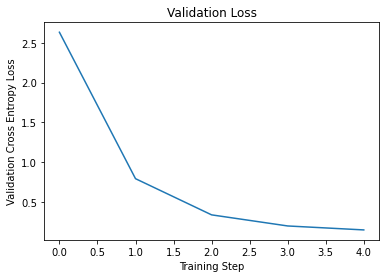

In [264]:
# Visualize loss curve

losses = history.history['val_loss']
plt.plot(losses)
plt.xlabel('Training Step')
plt.ylabel('Validation Cross Entropy Loss')
plt.title('Validation Loss')
plt.show()

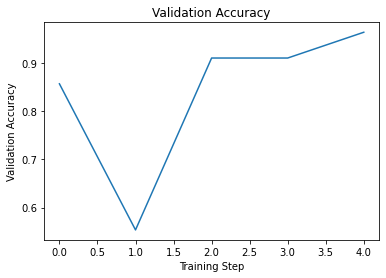

In [265]:
# Visualize accuracy

losses = history.history['val_acc']
plt.plot(losses)
plt.xlabel('Training Step')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy')
plt.show()

In [266]:
# Table of history

hist_df = pd.DataFrame(history.history)
hist_df

,loss,acc,val_loss,val_acc
0,100.124016,0.674208,2.631823,0.857143
1,4.075229,0.723982,0.792318,0.553571
2,0.590186,0.746606,0.337762,0.910714
3,0.519444,0.941177,0.198316,0.910714
4,0.204717,0.927602,0.148647,0.964286


In [267]:
model.save("/Users/johngalvin/Desktop/GitHub/Tensorflow/workspace/Lucy-Classification/models/model.h5")

/Users/johngalvin/miniforge3/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


## Prepare Test Set

In [281]:
# Preprocess the test images to expected shape

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_generator = test_datagen.flow_from_directory("../images/test/",
                                                    target_size=IMG_SIZE,
                                                    batch_size=1,
                                                    shuffle=True,
                                                    class_mode="categorical")

Found 28 images belonging to 2 classes.


## Test the Model

In [282]:
tf.keras.backend.clear_session()
model = load_model("/Users/johngalvin/Desktop/GitHub/Tensorflow/workspace/Lucy-Classification/models/model.h5")

In [283]:
predictions = model.predict(test_generator)

2022-06-11 15:33:11.349830: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [284]:
# Find index of max probability for each prediction

predictions = [np.argmax(item) for item in predictions]

In [285]:
num_correct = 0

for i in range(len(predictions)):
    if predictions[i] == test_generator.classes[i]:
        num_correct += 1
print (num_correct / len(test_generator.classes))

0.5
